# Using Reddit's API for Predicting Comments

In this project, we will practice two major skills. Collecting data via an API request and then building a binary predictor.

As we discussed in week 2, and earlier today, there are two components to starting a data science problem: the problem statement, and acquiring the data.

For this article, your problem statement will be: _What characteristics of a post on Reddit contribute most to the overall interaction (as measured by number of comments)?_

Your method for acquiring the data will be scraping the 'hot' threads as listed on the [Reddit homepage](https://www.reddit.com/). You'll acquire _AT LEAST FOUR_ pieces of information about each thread:
1. The title of the thread
2. The subreddit that the thread corresponds to
3. The length of time it has been up on Reddit
4. The number of comments on the thread

Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts whether or not a given Reddit post will have above or below the _median_ number of comments.

**BONUS PROBLEMS**
1. If creating a logistic regression, GridSearch Ridge and Lasso for this model and report the best hyperparameter values.
1. Scrape the actual text of the threads using Selenium (you'll learn about this in Webscraping II).
2. Write the actual article that you're pitching and turn it into a blog post that you host on your personal website.

### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to the URL below. 

*NOTE*: Reddit will throw a [429 error](https://httpstatuses.com/429) when using the following code:
```python
res = requests.get(URL)
```

This is because Reddit has throttled python's default user agent. You'll need to set a custom `User-agent` to get your request to work.
```python
res = requests.get(URL, headers={'User-agent': 'YOUR NAME Bot 0.1'})
```

In [1799]:
import emoji
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import seaborn as sns
import time
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [2]:
url = "http://www.reddit.com/hot.json"

In [3]:
## YOUR CODE HERE
headers = {'User-agent': 'Natalie H Bot 0.1'} # setting User-agent to my own name since Python's U-A is blocked
res = requests.get(url, headers=headers)
res.status_code

200

#### Use `res.json()` to convert the response into a dictionary format and set this to a variable. 

```python
data = res.json()
```

In [4]:
reddit_data = res.json()
print(sorted(reddit_data.keys()))
print(sorted(reddit_data['data'].keys())) # Checking keys under data
print(len(reddit_data['data']['children'])) # Checking number of posts under children

['data', 'kind']
['after', 'before', 'children', 'dist', 'modhash']
25


#### Getting more results

By default, Reddit will give you the top 25 posts:

```python
print(len(data['data']['children']))
```

If you want more, you'll need to do two things:
1. Get the name of the last post: `data['data']['after']`
2. Use that name to hit the following url: `http://www.reddit.com/hot.json?after=THE_AFTER_FROM_STEP_1`
3. Create a loop to repeat steps 1 and 2 until you have a sufficient number of posts. 

*NOTE*: Reddit will limit the number of requests per second you're allowed to make. When you create your loop, be sure to add the following after each iteration.

```python
time.sleep(3) # sleeps 3 seconds before continuing```

This will throttle your loop and keep you within Reddit's guidelines. You'll need to import the `time` library for this to work!

In [27]:
# Must keep posts separate so as not to reset it each time
posts = []

In [1911]:
after = None
for i in range(20):
    print(i)
    if after == None:
        params = {}
    else:
        params = {'after': after}
    url = 'https://www.reddit.com/hot.json'
    res = requests.get(url, params=params, headers=headers)
    if res.status_code == 200:
        reddit_data = res.json()
        posts.extend(reddit_data['data']['children'])
        after = reddit_data['data']['after']
    else:
        print(res.status_code)
        break
    time.sleep(3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [1916]:
# Saved a sample of display(posts) in separate .ipynb to help run this .ipynb faster
# display(posts)

In [1917]:
# Identifying number of unique posts from scrapes
len(set([p['data']['name'] for p in posts]))

5940

In [1918]:
unique_posts = posts_test_df.drop(labels=['data', 'kind'], axis=1)

more_unique = unique_posts.drop_duplicates('name', keep='last')
# By keeping last, we can use most recent number of comments/upvotes/gold

## (Optional) Collect more information

While we only require you to collect four features, there may be other info that you can find on the results page that might be useful. Feel free to write more functions so that you have more interesting and useful data.

In [1919]:
# Created a few lists for data to check out variables
# No downvotes_lists were created as there were zero downvotes in the scrapes

names_list = []        # post ID
num_comments_list = [] # number of comments in post (in scraping, took latest number)
subreddit_list = []    # name of subreddit
title_list = []        # title of post (string)
score_list = []        # overall score of post - this is artificially 'fuzzed' by Reddit per API description
unix_list = []         # post time creation
ups_list = []          # number of upvotes post had received (in scraping, took latest number)
domains_list = []      # domain of linked post
nsfw_list = []         # if post content was identified as 18 years+ 
gilded_list = []       # amount of gold post received (in scraping, took latest number)

for p in posts:
    names = (p['data']['name'])
    names_list.append(names)
    
    comments = (p['data']['num_comments'])
    num_comments_list.append(comments)
    
    subs = (p['data']['subreddit'])
    subreddit_list.append(subs)
    
    titles = (p['data']['title'])
    title_list.append(titles)
    
    scores = (p['data']['score'])
    score_list.append(scores)
    
    utcs = (p['data']['created_utc'])
    unix_list.append(utcs)
    
    upvotes = (p['data']['ups'])
    ups_list.append(upvotes)
    
    domains = (p['data']['domain'])
    domains_list.append(domains)
    
    nsfws = (p['data']['over_18'])
    nsfw_list.append(nsfws)
    
    golds = (p['data']['gilded'])
    gilded_list.append(golds)
    
    
# To convert UNIX times to current time zone value
import time

epoch_times = []

for i in unix_list:
    epoch_times.append(time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime(i)))

In [1920]:
# Instantiating dataframe and columns from above lists

posts_test_df = pd.DataFrame(posts)

posts_test_df['num_comments'] = pd.DataFrame(num_comments_list)
posts_test_df['subreddit'] = pd.DataFrame(subreddit_list)
posts_test_df['title'] = pd.DataFrame(title_list)
posts_test_df['name'] = pd.DataFrame(names_list)
posts_test_df['time_created'] = pd.DataFrame(epoch_times)
posts_test_df['upvotes'] = pd.DataFrame(ups_list)
posts_test_df['link_domains'] = pd.DataFrame(domains_list)
posts_test_df['is_nsfw'] = pd.DataFrame(nsfw_list)
posts_test_df['gold_received'] = pd.DataFrame(gilded_list)

posts_test_df.tail()

,data,kind,num_comments,subreddit,title,name,time_created,upvotes,link_domains,is_nsfw,gold_received
20995,"{'is_crosspostable': False, 'subreddit_id': 't...",t3,26,RetroFuturism,1957: Wernher Von Braun and his Moon Rocket co...,t3_8ocqxd,"Sun, 03 Jun 2018 18:38:59 +0000",410,i.redd.it,False,0
20996,"{'is_crosspostable': False, 'subreddit_id': 't...",t3,141,shield,Literally just a picture of the best avenger,t3_8o8677,"Sun, 03 Jun 2018 07:19:43 +0000",3689,i.redd.it,False,0
20997,"{'is_crosspostable': False, 'subreddit_id': 't...",t3,53,BreadStapledToTrees,We’re going to a family event. If there’s any ...,t3_8o9l70,"Sun, 03 Jun 2018 11:16:38 +0000",1667,i.redd.it,False,0
20998,"{'is_crosspostable': False, 'subreddit_id': 't...",t3,162,AnimalCrossing,5 hours of crafting into a half-minute highlig...,t3_8o7x20,"Sun, 03 Jun 2018 06:21:24 +0000",4688,v.redd.it,False,0
20999,"{'is_crosspostable': False, 'subreddit_id': 't...",t3,20,trashpandas,Wannabe trash panda......Trash possum.,t3_8oaqt5,"Sun, 03 Jun 2018 13:54:42 +0000",977,i.redd.it,False,0


### Save your results as a CSV
You may do this regularly while scraping data as well, so that if your scraper stops of your computer crashes, you don't lose all your data.

In [1921]:
# Export to csv
more_unique.to_csv('unique_posts.csv', index=False)

## Predicting comments using Random Forests + Another Classifier

#### Load in the the data of scraped results

In [1922]:
reddit_posts = pd.read_csv('unique_posts.csv')
reddit_posts.head()

,num_comments,subreddit,title,name,time_created,upvotes,link_domains,is_nsfw,gold_received
0,1242,funny,Apologies Accepted.,t3_8mzwn9,"Tue, 29 May 2018 10:19:33 +0000",55150,i.redd.it,False,0
1,129,OSHA,When you don’t have enough space,t3_8n02pw,"Tue, 29 May 2018 10:40:48 +0000",4255,i.redd.it,False,0
2,499,Showerthoughts,Life is just collecting people to come to your...,t3_8mz3rf,"Tue, 29 May 2018 08:30:42 +0000",18495,self.Showerthoughts,False,0
3,87,combinedgifs,free your mind,t3_8mz094,"Tue, 29 May 2018 08:16:23 +0000",7608,media.giphy.com,False,0
4,37,MurderedByWords,5 year old destruction,t3_8n1cpd,"Tue, 29 May 2018 13:19:52 +0000",1832,i.redd.it,False,0


#### We want to predict a binary variable - whether the number of comments was low or high. Compute the median number of comments and create a new binary variable that is true when the number of comments is high (above the median)

We could also perform Linear Regression (or any regression) to predict the number of comments here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW number of comments.

While performing regression may be better, performing classification may help remove some of the noise of the extremely popular threads. We don't _have_ to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of comment numbers. 

In [1923]:
# Checking out various quartile amounts for number of comments
display(reddit_posts['num_comments'].describe())

count     5781.000000
mean       278.951047
std        830.577267
min          0.000000
25%         37.000000
50%         91.000000
75%        241.000000
max      20350.000000
Name: num_comments, dtype: float64

In [1924]:
lower_quartile, upper_quartile = reddit_posts['num_comments'].quantile([0.25, 0.75])
# Tukey's outliers will be those that are 1.5 times greater than the interquartile range
tukeys_outliers = upper_quartile + (1.5 * (upper_quartile - lower_quartile))

# Three splits: 1) median, 2) upper quartile limit, 3) Tukey's outliers
reddit_posts['high_num_comments'] = reddit_posts['num_comments'] >= (np.median(reddit_posts['num_comments']))
reddit_posts['above_75_percent_median_comments'] = reddit_posts['num_comments'] >= upper_quartile
reddit_posts['outlier_num_comments'] = reddit_posts['num_comments'] >= tukeys_outliers

In [1925]:
print(reddit_posts['high_num_comments'].value_counts())
print()
print(reddit_posts['above_75_percent_median_comments'].value_counts())
print()
print(reddit_posts['outlier_num_comments'].value_counts())

True     2905
False    2876
Name: high_num_comments, dtype: int64

False    4335
True     1446
Name: above_75_percent_median_comments, dtype: int64

False    5151
True      630
Name: outlier_num_comments, dtype: int64


In [1926]:
reddit_posts.head(10)

,num_comments,subreddit,title,name,time_created,upvotes,link_domains,is_nsfw,gold_received,high_num_comments,above_75_percent_median_comments,outlier_num_comments
0,1242,funny,Apologies Accepted.,t3_8mzwn9,"Tue, 29 May 2018 10:19:33 +0000",55150,i.redd.it,False,0,True,True,True
1,129,OSHA,When you don’t have enough space,t3_8n02pw,"Tue, 29 May 2018 10:40:48 +0000",4255,i.redd.it,False,0,True,False,False
2,499,Showerthoughts,Life is just collecting people to come to your...,t3_8mz3rf,"Tue, 29 May 2018 08:30:42 +0000",18495,self.Showerthoughts,False,0,True,True,False
3,87,combinedgifs,free your mind,t3_8mz094,"Tue, 29 May 2018 08:16:23 +0000",7608,media.giphy.com,False,0,False,False,False
4,37,MurderedByWords,5 year old destruction,t3_8n1cpd,"Tue, 29 May 2018 13:19:52 +0000",1832,i.redd.it,False,0,False,False,False
5,35,HumansBeingBros,"Student from Egypt found $10,000 worth of gold...",t3_8mzd4b,"Tue, 29 May 2018 09:07:36 +0000",2833,i.imgur.com,False,0,False,False,False
6,81,Whatcouldgowrong,Let me throw this lit cigarette down this shaf...,t3_8n15di,"Tue, 29 May 2018 12:54:56 +0000",1216,i.imgur.com,False,0,False,False,False
7,149,crappyoffbrands,No comment on this.,t3_8mxhhg,"Tue, 29 May 2018 03:28:21 +0000",11291,i.redd.it,False,0,True,False,False
8,925,funny,"If you think professionals are expensive, hire...",t3_8myz29,"Tue, 29 May 2018 08:11:38 +0000",16875,i.redd.it,False,0,True,True,True
9,215,FortNiteBR,Get Down Mr. President!,t3_8myanf,"Tue, 29 May 2018 06:16:52 +0000",8880,gfycat.com,False,0,True,False,False


#### Thought experiment: What is the baseline accuracy for this model?

Since the baseline accuracy is the majority class, here it is posts that have at least the median number of comments or greater than the median.

#### Create a Random Forest model to predict High/Low number of comments using Sklearn. Start by ONLY using the subreddit as a feature. 

In [1927]:
print(reddit_posts['subreddit'].value_counts())
reddit_posts['subreddit_encoded'] = LabelEncoder().fit_transform(reddit_posts['subreddit'])

funny                   88
aww                     66
gaming                  61
pics                    53
todayilearned           45
gifs                    44
BlackPeopleTwitter      42
FortNiteBR              39
mildlyinteresting       37
PrequelMemes            36
memes                   34
Showerthoughts          31
worldnews               30
news                    29
AskReddit               28
oddlysatisfying         27
PewdiepieSubmissions    25
greentext               24
DeepFriedMemes          24
EarthPorn               23
videos                  23
PoliticalHumor          23
Kanye                   23
wholesomememes          22
interestingasfuck       22
DunderMifflin           21
food                    20
rupaulsdragrace         20
WhitePeopleTwitter      20
CrappyDesign            20
                        ..
Cooking                  1
HeavySeas                1
TopMindsOfReddit         1
running                  1
cyberpunkgame            1
ShitCosmoSays            1
M

In [1928]:
X = reddit_posts['subreddit_encoded']
y = reddit_posts['high_num_comments']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train.reshape(-1,1), y_train)
# Wouldn't accept one-dimensional array; had to re-shape X

print('Random Forest training score for median comments +: ', rf.score(X_train.reshape(-1,1), y_train))
print('Random Forest test score for median comments +: ', rf.score(X_test.reshape(-1,1), y_test))
print()

y = reddit_posts['above_75_percent_median_comments']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
rf.fit(X_train.reshape(-1,1), y_train)
print('Random Forest training score of >= 75% of comments: ', rf.score(X_train.reshape(-1,1), y_train))
print('Random Forest test score of >= 75% of comments: ', rf.score(X_test.reshape(-1,1), y_test))
print()

y = reddit_posts['outlier_num_comments']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
rf.fit(X_train.reshape(-1,1), y_train)
print('Random Forest training score for outliers: ', rf.score(X_train.reshape(-1,1), y_train))
print('Random Forest test score for outliers: ', rf.score(X_test.reshape(-1,1), y_test))


Random Forest training score for median comments +:  0.7988465974625144
Random Forest test score for median comments +:  0.7171507607192255

Random Forest training score of >= 75% of comments:  0.8283737024221454
Random Forest test score of >= 75% of comments:  0.80567081604426

Random Forest training score for outliers:  0.9116493656286044
Random Forest test score for outliers:  0.8955739972337483


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: FutureWarning: reshape is 

#### Create a few new variables in your dataframe to represent interesting features of a thread title.
- For example, create a feature that represents whether 'cat' is in the title or whether 'funny' is in the title. 
- Then build a new Random Forest with these features. Do they add any value?
- After creating these variables, use count-vectorizer to create features based on the words in the thread titles.
- Build a new random forest model with subreddit and these new features included.

In [1929]:
# Credit where credit is due:
# https://stackoverflow.com/questions/43146528/how-to-extract-all-the-emojis-from-text
def find_emojis(text):
    for i in text:
        if i in emoji.UNICODE_EMOJI:
            return 1
        else:
            return 0
        
reddit_posts['has_emojis'] = reddit_posts['title'].map(find_emojis)
# https://stackoverflow.com/questions/9012008/pythons-re-return-true-if-regex-contains-in-the-string
reddit_posts['has_cats'] = reddit_posts['title'].map(lambda x: bool(re.search(r"\b[catCAT]{3}\b", x)))
reddit_posts['has_trump'] = reddit_posts['title'].map(lambda x: bool(re.search(r"\b[trumpTRUMP]{5}\b", x)))
reddit_posts['has_hahas'] = reddit_posts['title'].map(lambda x: bool(re.search(r"\b[haha]{4}", x)))
reddit_posts['has_funny'] = reddit_posts['title'].map(lambda x: bool(re.search(r"\b[funnyFUNNY]{5}\b", x)))
reddit_posts['has_dogs'] = reddit_posts['title'].map(lambda x: bool(re.search(r"\b[dogDOG]{3}", x)))
reddit_posts['has_year'] = reddit_posts['title'].map(lambda x: bool(re.search(r"\b[yearYEAR]{4}", x)))
reddit_posts['has_best'] = reddit_posts['title'].map(lambda x: bool(re.search(r"\b[bestBEST]{4}\b", x)))

In [1950]:
# Checking 50 most frequent words in titles, after removing stopwords
words_in_titles = []
for x in reddit_posts['title']:
    words_in_titles.append(x)

cvec = CountVectorizer(ngram_range=(1,2),
                       stop_words='english', 
                       max_features=25)
cvec.fit_transform(words_in_titles)
cvec.get_feature_names()

['best',
 'day',
 'dog',
 'don',
 'good',
 'got',
 'guy',
 'just',
 'life',
 'like',
 'little',
 'man',
 'new',
 'oc',
 'old',
 'people',
 'post',
 'right',
 'think',
 'time',
 'today',
 've',
 'work',
 'year',
 'years']

In [1931]:
X = reddit_posts[['subreddit_encoded', 
                  'has_emojis', 
                  'has_cats',
                  'has_best', 
                  'has_year', 
                  'has_hahas',
                  'has_funny',
                  'has_dogs', 
                  'has_trump',
                  'has_best'
                 ]]
y = reddit_posts['high_num_comments']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf.fit(X_train, y_train)
print('Random Forest training score for median comments +: ', rf.score(X_train, y_train))
print('Random Forest test score for median comments +: ', rf.score(X_test, y_test))
print()

y = reddit_posts['above_75_percent_median_comments']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
rf.fit(X_train, y_train)
print('Random Forest training score of >= 75% of comments: ', rf.score(X_train, y_train))
print('Random Forest test score of >= 75% of comments: ', rf.score(X_test, y_test))
print()

y = reddit_posts['outlier_num_comments']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
rf.fit(X_train, y_train)
print('Random Forest training score for outliers: ', rf.score(X_train, y_train))
print('Random Forest test score for outliers: ', rf.score(X_test, y_test))


Random Forest training score for median comments +:  0.8147635524798155
Random Forest test score for median comments +:  0.7060857538035962

Random Forest training score of >= 75% of comments:  0.8382929642445214
Random Forest test score of >= 75% of comments:  0.7911479944674965

Random Forest training score for outliers:  0.9162629757785468
Random Forest test score for outliers:  0.8872752420470262


In [1932]:
# Using Sentinment Analyzer to determine how negative (neg), neutral (neu), or positive (pos) a post's title is
# The compound amount ranges from -1 (neg) to 1 (pos) for overall sentiment score.
# Adapted from: https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/

sia = SentimentIntensityAnalyzer()
sentiment_results = []

for i in reddit_posts['title']:
    polarity_score = sia.polarity_scores(i)
    polarity_score['post_title'] = i
    sentiment_results.append(polarity_score)
    
polarity_score_df = pd.DataFrame(sentiment_results)
polarity_score_df.head()

,compound,neg,neu,pos,post_title
0,0.2732,0.000,0.323,0.677,Apologies Accepted.
1,0.0000,0.000,1.000,0.000,When you don’t have enough space
2,-0.3612,0.217,0.783,0.000,Life is just collecting people to come to your...
3,0.5106,0.000,0.377,0.623,free your mind
4,-0.5719,0.649,0.351,0.000,5 year old destruction


In [1933]:
# Adding above dataframe to existing reddit_posts
reddit_posts_combined = pd.concat([reddit_posts, polarity_score_df], axis=1)
reddit_posts_sentiments = reddit_posts_combined.drop(labels='post_title', axis=1)

# Adding new columns for posts that are 'strong' in either direction
reddit_posts_sentiments['strongly_neg'] = reddit_posts_sentiments['compound'].map(lambda x: bool(x <= -0.33))
reddit_posts_sentiments['strongly_pos'] = reddit_posts_sentiments['compound'].map(lambda x: bool(x >= 0.33))
reddit_posts_sentiments['strong_compound'] = reddit_posts_sentiments['compound'].map(lambda x: bool(abs(x) >= 0.33))

# To add summary label column based on above
reddit_posts_sentiments['label'] = 0
reddit_posts_sentiments.loc[reddit_posts_sentiments['compound'] >= 0.33, 'label'] = 1
reddit_posts_sentiments.loc[reddit_posts_sentiments['compound'] <= -0.33, 'label'] = -1

reddit_posts_sentiments.head()

,num_comments,subreddit,title,name,time_created,upvotes,link_domains,is_nsfw,gold_received,high_num_comments,...,has_year,has_best,compound,neg,neu,pos,strongly_neg,strongly_pos,strong_compound,label
0,1242,funny,Apologies Accepted.,t3_8mzwn9,"Tue, 29 May 2018 10:19:33 +0000",55150,i.redd.it,False,0,True,...,False,False,0.2732,0.000,0.323,0.677,False,False,False,0
1,129,OSHA,When you don’t have enough space,t3_8n02pw,"Tue, 29 May 2018 10:40:48 +0000",4255,i.redd.it,False,0,True,...,False,False,0.0000,0.000,1.000,0.000,False,False,False,0
2,499,Showerthoughts,Life is just collecting people to come to your...,t3_8mz3rf,"Tue, 29 May 2018 08:30:42 +0000",18495,self.Showerthoughts,False,0,True,...,False,False,-0.3612,0.217,0.783,0.000,True,False,True,-1
3,87,combinedgifs,free your mind,t3_8mz094,"Tue, 29 May 2018 08:16:23 +0000",7608,media.giphy.com,False,0,False,...,False,False,0.5106,0.000,0.377,0.623,False,True,True,1
4,37,MurderedByWords,5 year old destruction,t3_8n1cpd,"Tue, 29 May 2018 13:19:52 +0000",1832,i.redd.it,False,0,False,...,True,False,-0.5719,0.649,0.351,0.000,True,False,True,-1


In [1934]:
reddit_posts_sentiments.columns

Index(['num_comments', 'subreddit', 'title', 'name', 'time_created', 'upvotes',
       'link_domains', 'is_nsfw', 'gold_received', 'high_num_comments',
       'above_75_percent_median_comments', 'outlier_num_comments',
       'subreddit_encoded', 'has_emojis', 'has_cats', 'has_trump', 'has_hahas',
       'has_funny', 'has_dogs', 'has_year', 'has_best', 'compound', 'neg',
       'neu', 'pos', 'strongly_neg', 'strongly_pos', 'strong_compound',
       'label'],
      dtype='object')

In [1935]:
X = reddit_posts_sentiments[['subreddit_encoded', 
                             'strong_compound', 
                             'is_nsfw', 
                             'gold_received',
                             'upvotes',
                             'has_emojis',
                             'has_cats',
                             'has_best',
                             'has_year',
                             'has_hahas',
                             'has_funny',
                             'has_dogs',
                             'has_trump',
                             'has_best'
                            ]]
y = reddit_posts_sentiments['high_num_comments']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf.fit(X_train, y_train)
print('Random Forest training score for median # of comments: ', rf.score(X_train, y_train))
print('Random Forest test score for median # of comments: ', rf.score(X_test, y_test))
print('Cross Val scores: ', cross_val_score(rf, X_train, y_train, cv=3))
print()

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print('kNN training score for median # of comments: ', knn.score(X_train, y_train))
print('kNN test score for median # of comments: ', knn.score(X_test, y_test))
print('Cross Val scores: ', cross_val_score(knn, X_train, y_train, cv=3))
print()

bc = BaggingClassifier(random_state=42)
bc.fit(X_train, y_train)
print('Bagging training score for median # of comments: ', bc.score(X_train, y_train))
print('Bagging test score for median # of comments: ', bc.score(X_test, y_test))
print('Cross Val scores: ', cross_val_score(bc, X_train, y_train, cv=3))

Random Forest training score for median # of comments:  0.9829296424452134
Random Forest test score for median # of comments:  0.7496542185338866
Cross Val scores:  [0.74117647 0.77370242 0.76885813]

kNN training score for median # of comments:  0.8366782006920416
kNN test score for median # of comments:  0.7261410788381742
Cross Val scores:  [0.71695502 0.72941176 0.72456747]

Bagging training score for median # of comments:  0.9826989619377162
Bagging test score for median # of comments:  0.7461964038727524
Cross Val scores:  [0.73148789 0.75709343 0.75432526]


In [1936]:
y = reddit_posts_sentiments['above_75_percent_median_comments']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf.fit(X_train, y_train)
print('Random Forest training score for >= 75% of comments: ', rf.score(X_train, y_train))
print('Random Forest test score for >= 75% of comments: ', rf.score(X_test, y_test))
print('Cross Val scores: ', cross_val_score(rf, X_train, y_train, cv=3))
print()

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print('kNN training score for >= 75% of comments: ', knn.score(X_train, y_train))
print('kNN test score for >= 75% of comments: ', knn.score(X_test, y_test))
print('Cross Val scores: ', cross_val_score(knn, X_train, y_train, cv=3))
print()

bc = BaggingClassifier(random_state=42)
bc.fit(X_train, y_train)
print('Bagging training score for >= 75% of comments: ', bc.score(X_train, y_train))
print('Bagging test score for >= 75% of comments: ', bc.score(X_test, y_test))
print('Cross Val scores: ', cross_val_score(bc, X_train, y_train, cv=3))

Random Forest training score for >= 75% of comments:  0.9868512110726644
Random Forest test score for >= 75% of comments:  0.826417704011065
Cross Val scores:  [0.82918396 0.82629758 0.82479224]

kNN training score for >= 75% of comments:  0.8876585928489042
kNN test score for >= 75% of comments:  0.813969571230982
Cross Val scores:  [0.81466113 0.81453287 0.80609418]

Bagging training score for >= 75% of comments:  0.9831603229527105
Bagging test score for >= 75% of comments:  0.8319502074688797
Cross Val scores:  [0.83333333 0.80899654 0.82409972]


In [1937]:
y = reddit_posts_sentiments['outlier_num_comments']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf.fit(X_train, y_train)
print('Random Forest training score for outliers: ', rf.score(X_train, y_train))
print('Random Forest test score for outliers: ', rf.score(X_test, y_test))
print('Cross Val scores: ', cross_val_score(rf, X_train, y_train, cv=3))
print()

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print('kNN training score for outliers: ', knn.score(X_train, y_train))
print('kNN test score for outliers: ', knn.score(X_test, y_test))
print('Cross Val scores: ', cross_val_score(knn, X_train, y_train, cv=3))
print()

bc = BaggingClassifier(random_state=42)
bc.fit(X_train, y_train)
print('Bagging training score for outliers: ', bc.score(X_train, y_train))
print('Bagging test score for outliers: ', bc.score(X_test, y_test))
print('Cross Val scores: ', cross_val_score(bc, X_train, y_train, cv=3))

Random Forest training score for outliers:  0.9891580161476355
Random Forest test score for outliers:  0.9045643153526971
Cross Val scores:  [0.91009682 0.91626298 0.92036011]

kNN training score for outliers:  0.9370242214532872
kNN test score for outliers:  0.8941908713692946
Cross Val scores:  [0.89764869 0.89480969 0.90858726]

Bagging training score for outliers:  0.9891580161476355
Bagging test score for outliers:  0.9059474412171508
Cross Val scores:  [0.91078838 0.90726644 0.91620499]


#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 

(See above cross val scores.)

#### Repeat the model-building process with a non-tree-based method.

(See kNN classifier above.)

#### Use Count Vectorizer from scikit-learn to create features from the thread titles. 
- Examine using count or binary features in the model
- Re-evaluate your models using these. Does this improve the model performance? 
- What text features are the most valuable? 

Since we extracted the most common words via CountVectorizer previously, we'll use TF-IDF here instead.
Additionally, adding these strings to the model doesn't show to improve performance overall.

In [1938]:
X = reddit_posts_sentiments['title']
y = reddit_posts_sentiments['high_num_comments']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = 'english',   \
                             ngram_range = (1, 2),
                             max_features = 5000) 

X_train_cvec = vectorizer.fit_transform(X_train)
X_test_cvec = vectorizer.transform(X_test)

rf.fit(X_train_cvec, y_train)
rf.score(X_train_cvec, y_train)
rf.score(X_test_cvec, y_test)

0.5656984785615491

In [1939]:
tvec = TfidfVectorizer(stop_words='english',
                       max_features=20
                      )
tvec.fit_transform(reddit_posts_sentiments['title'])
tvec.get_feature_names()

['day',
 'don',
 'good',
 'got',
 'just',
 'life',
 'like',
 'little',
 'man',
 'new',
 'oc',
 'old',
 'people',
 'post',
 'right',
 'time',
 'today',
 've',
 'year',
 'years']

In [1940]:
# Created pipelines to manage model with both text and numbers
# https://www.kaggle.com/baghern/a-deep-dive-into-sklearn-pipelines

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

# Create classes to handle different types of features (words vs numbers)
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

X = reddit_posts_sentiments[['title',
                             'subreddit_encoded', 
                             'strong_compound', 
                             'is_nsfw', 
                             'gold_received',
                             'upvotes',
                             'has_emojis',
                             'has_cats',
                             'has_best',
                             'has_year',
                             'has_hahas',
                             'has_funny',
                             'has_dogs',
                             'has_trump',
                             'has_best'
                            ]]
y = reddit_posts_sentiments['high_num_comments']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Use pipelines to integrate both feature types into one model
word_pipeline = Pipeline([
    ('selector', TextSelector(key='title')),
    ('tfidf', TfidfVectorizer())])

nonword_pipeline = Pipeline([
    ('selector', NumberSelector(key='has_emojis')),
    ('ss', StandardScaler())])

merge = FeatureUnion([
    ('word', word_pipeline),
    ('nonword', nonword_pipeline)])

main_pipeline = Pipeline([
    ('merger', merge),
    ('rf', RandomForestClassifier())])

main_pipeline.fit(X_train, y_train)
print('Random Forest + TF-IDF training score for median comments: ', main_pipeline.score(X_train, y_train))
print('Random Forest + TF-IDF test score for median comments: ', main_pipeline.score(X_test, y_test))
print()

y = reddit_posts_sentiments['above_75_percent_median_comments']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
main_pipeline.fit(X_train, y_train)
print('Random Forest + TF-IDF training score for >= 75% of comments: ', main_pipeline.score(X_train, y_train))
print('Random Forest + TF-IDF test score for >= 75% of comments: ', main_pipeline.score(X_test, y_test))
print()


y = reddit_posts_sentiments['outlier_num_comments']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
main_pipeline.fit(X_train, y_train)
print('Random Forest + TF-IDF training score for outliers: ', main_pipeline.score(X_train, y_train))
print('Random Forest + TF-IDF test score for outliers: ', main_pipeline.score(X_test, y_test))

Random Forest + TF-IDF training score for median comments:  0.9709342560553633
Random Forest + TF-IDF test score for median comments:  0.553941908713693

Random Forest + TF-IDF training score for >= 75% of comments:  0.9591695501730104
Random Forest + TF-IDF test score for >= 75% of comments:  0.7344398340248963

Random Forest + TF-IDF training score for outliers:  0.9730103806228374
Random Forest + TF-IDF test score for outliers:  0.876210235131397


# Taking a closer look at the impact of Sentiment Analysis on the model

In [1951]:
X = reddit_posts_sentiments['strong_compound']
y = reddit_posts_sentiments['high_num_comments']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
rf.fit(X_train.reshape(-1,1), y_train)
print(rf.score(X_train.reshape(-1,1), y_train))
print(rf.score(X_test.reshape(-1,1), y_test))

0.5144175317185697
0.529045643153527


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


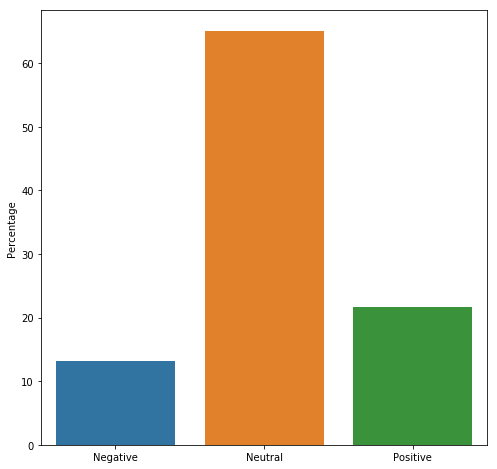

In [1942]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = reddit_posts_sentiments['label'].value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

In [1943]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=50)

positive_titles = list(reddit_posts_sentiments[reddit_posts_sentiments.label == 1].title)
tfidf.fit_transform(positive_titles)
fifty_positive_words = tfidf.get_feature_names()

negative_titles = list(reddit_posts_sentiments[reddit_posts_sentiments.label == -1].title)
tfidf.fit_transform(negative_titles)
fifty_negative_words = tfidf.get_feature_names()

In [1944]:
positive_titles

['free your mind',
 'What is most addictive game you ever played?',
 'UK Brexit proposals nominated for Hugo Award in Fantasy category',
 'Interesting title about titties',
 'CMV: There should be no separate minimum wage for waiters or "tipped" employees. And tipping should not be a social "expectation" in pretty much every dining situation &amp; other places where tips are "expected" as a given. Waiters &amp; others should get paid a fair market wage by employers.',
 'Guy encourages bird',
 'Smile for the camera!',
 'This was the TOP COMMENT',
 'Who else is happy that the Imperial Army Infantry troopers are finally getting some of the limelight?',
 'When your weekend looks this good',
 'Just moved from the Oneplus 5T to the iPhone X. Loving it so far!',
 'A beautiful Red Fox',
 'X-Files "The truth is out there" - Done by Austin at Sacred Art tattoo - Springfield, MO. Got this two years ago and is still my favorite',
 'Beefcake was a bait dog found near death and my friend rescued him 

In [1945]:
negative_titles

['Life is just collecting people to come to your funeral.',
 '5 year old destruction',
 'Even in another world Obito is scared of Itachi.',
 'Half in the Bag: Solo: A Star Wars Story',
 'Kerr with the Facts. Iggy doesn’t get hurt, series was over quick. Via @MarcJSpearsESPN',
 'Forbidden Bread (microwaved soap)',
 'I lied to my boyfriend.',
 "Hello there, did you ever hear the story of the droid attack on the wookie's high ground?",
 'LPT: Statistically, the chance of there being a bomb on your plane is really low, but the chance of TWO bombs is statistically impossible. So to be sure to avoid people blowing your plane up, you should always bring your own bomb with you',
 'Rain + Thunderblade = Effortless Remote Kills',
 'Shroud &amp; Doc get their own Weapon Skins!',
 'The Lancia Stratos Zero 1970, nothing but speed and violence',
 'Heartbroken mother dog reunited with puppies.',
 'Me this Thursday at 8pm wondering why I have to suffer',
 'Deception 💯',
 'This recruitment firm is seek

In [1946]:
fifty_positive_words

['best',
 'better',
 'day',
 'don',
 'free',
 'friend',
 'friends',
 'good',
 'got',
 'great',
 'guys',
 'happy',
 'help',
 'just',
 'life',
 'like',
 'little',
 'love',
 'new',
 'play',
 'post',
 'time',
 'today',
 've',
 'years']

In [1947]:
fifty_negative_words

['bad',
 'car',
 'don',
 'fuck',
 'just',
 'life',
 'make',
 'man',
 'new',
 'old',
 'people',
 'poor',
 'shit',
 'star',
 'star wars',
 'think',
 'til',
 'time',
 'trump',
 'war',
 'wars',
 'world',
 'wrong',
 'year',
 'years']

In [1948]:
X = reddit_posts_sentiments['strong_compound']
y = reddit_posts_sentiments['num_comments']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(random_state=42)
rfr.fit(X_train.reshape(-1,1), y_train)
print(rfr.score(X_train.reshape(-1,1), y_train))
print(rfr.score(X_test.reshape(-1,1), y_test))

X = reddit_posts_sentiments['strongly_neg']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
rfr.fit(X_train.reshape(-1,1), y_train)
print(rfr.score(X_train.reshape(-1,1), y_train))
print(rfr.score(X_test.reshape(-1,1), y_test))

X = reddit_posts_sentiments['strongly_pos']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
rfr.fit(X_train.reshape(-1,1), y_train)
print(rfr.score(X_train.reshape(-1,1), y_train))
print(rfr.score(X_test.reshape(-1,1), y_test))

0.0006515348677391675
0.0005061274646567249
0.00331158090881567
0.0034471064741369295
0.0001794490904288848
5.588348930496423e-05


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: FutureWarning: reshape is d

In [1949]:
X = reddit_posts_sentiments['label']
y = reddit_posts_sentiments['outlier_num_comments']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

rf.fit(X_train.reshape(-1,1), y_train)
print(rf.score(X_train.reshape(-1,1), y_train))
print(rf.score(X_test.reshape(-1,1), y_test))

X = reddit_posts_sentiments['strongly_neg']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
rf.fit(X_train.reshape(-1,1), y_train)
print(rf.score(X_train.reshape(-1,1), y_train))
print(rf.score(X_test.reshape(-1,1), y_test))

X = reddit_posts_sentiments['strongly_pos']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
rf.fit(X_train.reshape(-1,1), y_train)
print(rf.score(X_train.reshape(-1,1), y_train))
print(rf.score(X_test.reshape(-1,1), y_test))

0.895040369088812
0.8789764868603043
0.895040369088812
0.8789764868603043
0.895040369088812
0.8789764868603043


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: FutureWarning: reshape is de

# Executive Summary
---
Put your executive summary in a Markdown cell below.

Based on the above results, we can make the following interpretations:

One: subreddit popularity is a moderately strong indicator of the success of a "hot" thread on Reddit. 

Using CountVectorizer and TF-IDF to determine the most popular words across post titles, after removing stop words, won't provide an immense insight for our Classification models. This could be for several reasons, however, and there is room here to clean our data further to search for improvement. For example: if we could remove foreign languages, we could potentially allay some of the noise introduced into the model at fitting. However, even with features as relatively universal as emojis, the model couldn't be improved significantly with any particular group of features.

Given our relatively small data above the 75% mark of comments on a thread, bagging classifiers can only assist so much without overfitting on our training set, as evidenced above.

Finally, in trying to run a sentiment analysis of the titles of the posts, the limitations of the analysis are very clear. Redditors are known for their wit and sarcasm, and SIA is only able to pick up on so much creative language. In a cursory glance at titles that are marked as 'strongly' positive or negative, it is easy to see where the analyzer has limitations. Furthermore, there are many expressions and acronyms that the analyzer likely isn't ready to begin analyzing adequately, thus affecting the true compound score of a post. 

Another side effect of using SIA is seen in the overwhelming volume of posts that are categorized as simply 'neutral', leaving us with very little data as either strongly negative or positive otherwise. And while a strong compound score can be a good indicator of the popularity of a post in terms of the number of comments, it should be noted that the model strangely predicts roughly 50% R-squared when guessing if the number of posts will be at least above the median number of posts for all posts scraped, roughly 75% when classifying the top quarter of posts, and roughly 10-12% when classifying Tukey's outliers which is also roughly how many of these posts fall into this category.

Moreover, when attempting to use a Regressor in place of a Classifier model, the model fairs almost as well as random chance in predicting the number of comments a post will generate, suggesting that many of the above reasons may have an impact.

As such, there is still a long way to go before predicting if positive or negative titles, or certain buzzwords featured in various titles, will be able to predict the success of a Reddit post.

https://docs.google.com/presentation/d/1nS5WGATrDfY3XgqwBBtbPvphVv7-vRL7kj-eAJF4qdg/edit?usp=sharing

### BONUS
Refer to the README for the bonus parts